#### 
This notebook will obtain age observations by running modflow and modpath. It requires heads and budget files from a modflow run, initial value(s) for pososity. This notebook will create a file of 50 age observations that can be used for running the inverse model to estimate transport parameter(s) - porosity based upon the original observations of ages.

This notebook will change the single porosity value of previous runs to 4 zones (matching K zones used in other runs) with 4 porosity values.  Porosity values will be calculated by using eqn for a line of proportionality between lnK and a range of porosity.

In [1]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import flopy as fp
import subprocess as sp

In [2]:
# Insert name of data file -if SGEMS use name of exported CSV file
data = np.loadtxt('AA_FTestNewSimK', skiprows=1)

In [3]:
data

array([ 4.54677,  4.57565,  4.57176, ...,  6.17157,  6.14521,  6.18599])

0.18490155905734182

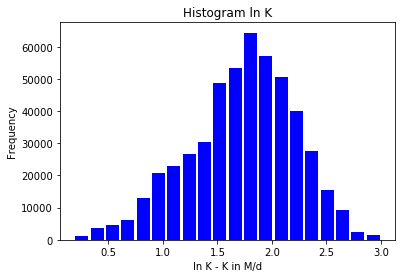

In [4]:
# Do histogram early - before reshaping - later one does not work
lndata = np.log(data)
plt.hist(lndata, 20,rwidth=0.85, color='Blue')
plt.title("Histogram ln K")
plt.xlabel("ln K - K in M/d")
plt.ylabel("Frequency")
fig = plt.gcf()
# Minimum ln value
minln = lndata.min()
minln


In [6]:
maxln = lndata.max()
maxln

2.9997890337637747

1.2031000000000001

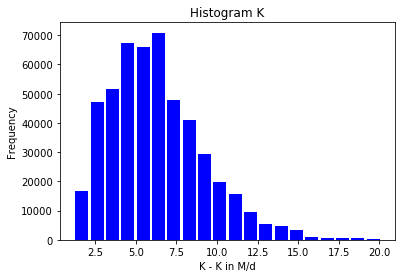

In [7]:
# Draw histogram of K
ddata = data
plt.hist(ddata, 20,rwidth=0.85, color='Blue')
plt.title("Histogram K")
plt.xlabel( "K - K in M/d")
plt.ylabel("Frequency")
fig = plt.gcf()
# Minimum ln value
min = ddata.min()
min

In [8]:
# Reshape data to match modflow 2D K-array: 500 rows (x),1000 columns(y)
nrow = 500
ncol = 1000
nlay = 1
data = data.reshape(nrow,ncol)[::-1]

In [9]:
data

array([[ 12.3473 ,  12.3496 ,  12.4445 , ...,   6.17157,   6.14521,
          6.18599],
       [ 12.4218 ,  12.4038 ,  12.3859 , ...,   6.07676,   6.10235,
          6.09059],
       [ 12.4352 ,  12.4128 ,  12.4057 , ...,   6.04605,   6.02746,
          6.06188],
       ..., 
       [  4.65467,   4.67207,   4.69169, ...,   6.98886,   7.01303,
          6.96291],
       [  4.645  ,   4.64063,   4.62868, ...,   6.99395,   6.98186,
          6.96227],
       [  4.54677,   4.57565,   4.57176, ...,   7.02553,   7.00612,
          6.93373]])

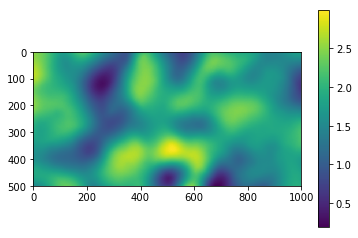

In [10]:
# Check view of data as 2D plot - in numpy "log" is natural log; log base 10 is "log10"
# This should resemble plots made of the same reality in SGEMS
lndata = np.log(data)
plt.imshow(lndata, interpolation='Nearest')
plt.colorbar()

In [11]:
lndata

array([[ 2.51343742,  2.51362367,  2.52127876, ...,  1.81995326,
         1.81567292,  1.82228706],
       [ 2.51945299,  2.51800288,  2.51655873, ...,  1.80447166,
         1.80867394,  1.80674496],
       [ 2.52053116,  2.5187282 ,  2.51815604, ...,  1.79940517,
         1.79632569,  1.80201998],
       ..., 
       [ 1.53787102,  1.54160223,  1.54579286, ...,  1.94431745,
         1.94776985,  1.94059749],
       [ 1.53579137,  1.53485013,  1.53227173, ...,  1.94504549,
         1.94331536,  1.94050557],
       [ 1.51441709,  1.52074877,  1.51989825, ...,  1.94955066,
         1.94678405,  1.93639791]])

In [12]:
# Check min ln value 
minln = lndata.min()
minln

0.18490155905734182

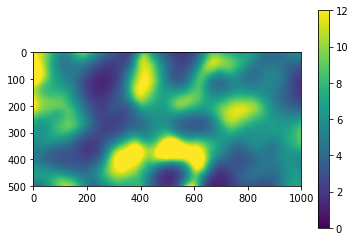

In [13]:
# Plot 2D K values
plt.imshow(data, interpolation='Nearest', vmin=0, vmax=12)
plt.colorbar()

In [14]:
# Maximum K value
maxdata = data.max()
maxdata


20.081299999999999

In [15]:
# Minimum K value
mindata = data.min()
mindata

1.2031000000000001

In [16]:
np.mean(data)

6.2906629789199995

In [17]:
# Modflow-NWT set up and run - change modelname for new runs  
# Create model files and run modflow
ml = fp.modflow.Modflow(modelname='D_Flow1',version = 'mfnwt', exe_name ='C:/WRDAPP/MODFLOW-NWT_1.0.9/bin/MODFLOW-NWT_64.exe')
name = 'D_Flow1'
# Inititialize variables
h = 1
k = 1
h1 = 30
bot = -30
delrow = 1
delcol = 1
hk = data
# Set head for start of flow
head_left = 30.
# Set head for end of flow
head_right = 20.
# Set iniital head for all cells 
head_initial_all = 25.

# Create high K at left and right boundaries - 2 orders of mag > maximum input K 
maxdata = data.max()
hk[:, 0] = maxdata*100
hk[:, -1]= maxdata*100

# Call Modflow dis routine to create .dis file
dis = fp.modflow.ModflowDis(ml, nlay = 1, nrow=nrow, ncol = ncol, delr = delrow, delc=delcol, top = 0, botm = bot, laycbd=0)
#
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1   
ibound[:, :, -1] = -1   

# Create array for starting head values
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)

# Change starting head for all cells to initial value  
strt[:,:,:] = head_initial_all
# Then change starting head for column 0 to head_head 
strt[:, :, 0] = head_left
# Then change starting head for last column to head_right
strt[:, :, -1] = head_right

# Add pumping well - flowrate = 500 m3/day
lrcq = {0:[0, 199, 699, -500.0]}
wel = fp.modflow.ModflowWel(ml, ipakcb=53, stress_period_data=lrcq, extension='wel', unitnumber=20)

# Call Modflow Basic routine to create .bas file
bas = fp.modflow.ModflowBas(model=ml,ibound=ibound, strt=strt,ixsec=False,ichflg=True, stoper=None, hnoflo=-999.99,extension = 'bas', unitnumber=13)

#
oc = fp.modflow.ModflowOc(ml, ihedfm=0, iddnfm=0, chedfm=None, cddnfm=None, cboufm=None, 
                              compact=True, stress_period_data={(0, 0): ['save head', 'save budget']}, 
                              extension=['oc', 'hds', 'ddn', 'cbc'], unitnumber=[14, 51, 52, 53])
oc
# Change head tolerance to .001
   
# Call Modflow Nwt routine to create .nwt file 
nwt = fp.modflow.ModflowNwt(ml, headtol=0.001, fluxtol=500, maxiterout=100, 
                                thickfact=1e-05, linmeth=2, iprnwt=1, ibotav=0, options='COMPLEX')

# Change layer type to 0

# Change 'iupwcb=53' to 'ipakcb=53' 
# Call Modflow upw routine to create .upw file
upw = fp.modflow.ModflowUpw(ml, laytyp=0, layavg=0, chani=1.0, layvka=1, laywet=0, ipakcb=53, 
                                hdry=1, iphdry=1, hk=hk, hani=1.0, vka=1.0, 
                                noparcheck=False, extension='upw', 
                                unitnumber=31)
#
ml.write_input()

# Run Modflow with files created above
success,output = ml.run_model()
 

FloPy is using the following executable to run the model: C:/WRDAPP/MODFLOW-NWT_1.0.9/bin/MODFLOW-NWT_64.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.2, 9/15/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: D_Flow1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/03/11 19:27:30

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/03/11 19:28:26
 Elapsed run time: 56.270 Seconds

  Normal termination of simulation


In [18]:
print("ml_run_model = %s" % success)

ml_run_model = True


New syntax for importing heads

In [19]:
ml.name

'D_Flow1'

In [20]:
ml

MODFLOW 1 layer(s), 500 row(s), 1000 column(s), 1 stress period(s)

New syntax for importing heads

In [23]:
# Insert name of modflow output formatted head data file 
head_file = 'D_Flow1.hds'
head_object = fp.utils.HeadFile(head_file)
heads = head_object.get_data()

In [24]:
heads.shape

(1, 500, 1000)

In [25]:
heads

array([[[ 30.        ,  29.99760437,  29.99285507, ...,  20.01011086,
          20.00337982,  20.        ],
        [ 30.        ,  29.99761009,  29.99285889, ...,  20.01010704,
          20.0033741 ,  20.        ],
        [ 30.        ,  29.99761009,  29.99285889, ...,  20.01010704,
          20.00337791,  20.        ],
        ..., 
        [ 30.        ,  29.99305153,  29.97920036, ...,  20.00690079,
          20.00230408,  20.        ],
        [ 30.        ,  29.99306107,  29.97920799, ...,  20.00690842,
          20.00230789,  20.        ],
        [ 30.        ,  29.99306297,  29.97921181, ...,  20.00691414,
          20.00231171,  20.        ]]], dtype=float32)

In [26]:
# Head value at the pumping well
heads[0,199,699]

19.751289

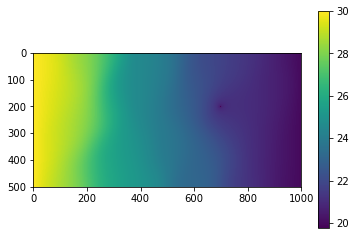

In [27]:
plt.imshow(heads[0, :, :], interpolation='Nearest')#,aspect=1.2)
plt.colorbar()

To create observations, first make a matrix of grid coordinates using a flopy method of the dis object and using meshgrid to flesh out the coordinate arrays. Then sample them using a step size of 50. Also sample the heads using a step size of 50, et voila, you have an observation data set.

In [28]:
a = np.load('RandomObs.npy')

is is ok to say y,x,z - I feel  like I am switching x & y but scatter plots work - so that confuses me - my obs files show them switched

Zip the data together to make a plottable array

In [29]:
b = a[:,0]

c= a[:,1]

d= a[:,2]

b,c,d

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]),
 array([269, 179, 140,  94, 216, 417, 176, 405, 279,  70, 406, 395, 220,
        308,  38,  75, 433,  27,  38, 310, 338, 364, 173, 218, 346, 416,
        102, 411, 451, 425,  35, 434, 181, 141, 176,  75,  47, 184,  46,
        392, 166, 354, 312, 259, 209, 320, 114, 346, 213, 176]),
 array([196,  77, 703,  63, 790, 472, 706, 656, 285, 891, 605, 296, 338,
        497, 450, 653, 659, 185, 307, 675,  71, 701, 373, 889, 874, 347,
        286, 957, 172, 326, 190, 589, 218, 445, 816, 334, 505, 436,  55,
         54, 602, 232, 151, 261,  65, 510, 542, 594, 966, 243]))

In [30]:
#Find index positions where 3D-array meets MULTIPLE conditions

index_pos = np.where((heads[:,:,:]==19.751289)) #& (heads[:,1]== 473) & (heads[:,2]==459))
index_pos

(array([0], dtype=int64), array([199], dtype=int64), array([699], dtype=int64))

In [31]:
head_obs = heads[b,c,d]
head_obs

array([ 28.10085106,  29.42650795,  21.50626373,  29.63387871,
        21.10994148,  24.25179863,  21.17774391,  22.79533386,
        26.22420692,  20.72533798,  23.11175156,  25.72019005,
        25.27002525,  23.87481308,  24.29122353,  22.06710243,
        22.82064056,  28.33154106,  25.98452759,  22.17912865,
        29.31162453,  22.21613121,  24.73497963,  20.71090698,
        20.72928047,  25.35579681,  26.13246918,  20.20901108,
        27.7673645 ,  25.52124977,  28.28478432,  23.18832016,
        27.85590553,  24.25201035,  21.02971458,  25.17673874,
        23.81898117,  24.28756142,  29.70381165,  29.45230865,
        22.55241394,  26.80316544,  28.55704117,  26.83341789,
        29.49299812,  23.79561615,  23.21359825,  23.15140533,
        20.23247528,  27.24829292], dtype=float32)

In [32]:
obs_data = np.array(list(zip(d.ravel(), c.ravel(), head_obs.ravel())))

In [33]:
obs_data.shape

(50, 3)

In [34]:
obs_data[0:9,0:3]

array([[ 196.        ,  269.        ,   28.10085106],
       [  77.        ,  179.        ,   29.42650795],
       [ 703.        ,  140.        ,   21.50626373],
       [  63.        ,   94.        ,   29.63387871],
       [ 790.        ,  216.        ,   21.10994148],
       [ 472.        ,  417.        ,   24.25179863],
       [ 706.        ,  176.        ,   21.17774391],
       [ 656.        ,  405.        ,   22.79533386],
       [ 285.        ,  279.        ,   26.22420692]])

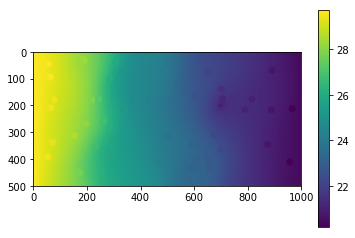

In [35]:
plt.imshow(heads[0, :, :], interpolation='Nearest')
plt.scatter(obs_data[:,0], obs_data[:,1], c=obs_data[:,2])
plt.colorbar()

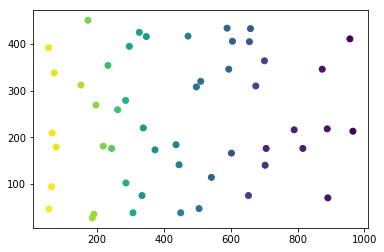

In [36]:
#plt.imshow(heads[0, :, :], interpolation='Nearest')
plt.scatter(obs_data[:,0], obs_data[:,1], c=obs_data[:,2])
#plt.colorbar()

The next code generates an array of particle locations for each of the open circles above. The format is required byy MODPATH.

In [37]:
total_parts = obs_data.shape[0]
times = np.zeros((total_parts))
particles = np.zeros( ( total_parts, 11 ) )
particles[:, 0] = np.arange( 1, total_parts + 1 )
label = ['obs_{}'.format(item) for item in particles[:, 0]]
particles[:, 1] = 1
particles[:, 2] = 1
particles[:, 3] = 1
particles[:, 4] = obs_data[:, 1] 
particles[:, 5] = obs_data[:, 0] 
particles[:, 6] = 0.5
particles[:, 7] = 0.5
particles[:, 8] = 0.5
particles[:, 9] = 0.0
particles[:, 10] = particles[:, 0]

In [38]:
np.set_printoptions(suppress=True, precision=3)
particles

array([[   1. ,    1. ,    1. ,    1. ,  269. ,  196. ,    0.5,    0.5,
           0.5,    0. ,    1. ],
       [   2. ,    1. ,    1. ,    1. ,  179. ,   77. ,    0.5,    0.5,
           0.5,    0. ,    2. ],
       [   3. ,    1. ,    1. ,    1. ,  140. ,  703. ,    0.5,    0.5,
           0.5,    0. ,    3. ],
       [   4. ,    1. ,    1. ,    1. ,   94. ,   63. ,    0.5,    0.5,
           0.5,    0. ,    4. ],
       [   5. ,    1. ,    1. ,    1. ,  216. ,  790. ,    0.5,    0.5,
           0.5,    0. ,    5. ],
       [   6. ,    1. ,    1. ,    1. ,  417. ,  472. ,    0.5,    0.5,
           0.5,    0. ,    6. ],
       [   7. ,    1. ,    1. ,    1. ,  176. ,  706. ,    0.5,    0.5,
           0.5,    0. ,    7. ],
       [   8. ,    1. ,    1. ,    1. ,  405. ,  656. ,    0.5,    0.5,
           0.5,    0. ,    8. ],
       [   9. ,    1. ,    1. ,    1. ,  279. ,  285. ,    0.5,    0.5,
           0.5,    0. ,    9. ],
       [  10. ,    1. ,    1. ,    1. ,   70. ,  891. ,

In [39]:
particles[0,4]

269.0

In [40]:
particles[0,5]

196.0

The next cell writes the particle starting locations to a file that can be read by MODPATH.  Some required header information is included. 

In [41]:
PartStartForm = '%6d %6d %3d %3d %3d %3d %12.9f %12.9f %12.9f %12.9e %15d'
line = '{:5d}\n{:5d}\n'.format(1, 1)
line = line + '{:s}\n{:5d}'.format('group', total_parts)
dst_pth = '{}.loc'.format(ml.name)
np.savetxt(dst_pth, particles, delimiter=' ', fmt=PartStartForm, header=line, comments='')

In [42]:
ml.name

'D_Flow1'

In [43]:
'{}.hds'.format(ml.name)

'D_Flow1.hds'

The next cell creates the porosity array by using previous code (runparsmodflow1v4.py) used to create K zones and converting K to porosity using proportional relationship - see comment at start of this notebook.

In [44]:
# Create a matrix of 4 zones by stepping through each cell and assigning it to one of 4 ranges
# Change zones for better distribution - see BU slides

zone = np.zeros((500,1000))
mindata= hk.min()
for i in range(0,500):
    for j in range(0,1000):
        if hk[i,j] > mindata and hk[i,j]< 4.0:
            zone[i,j] = 1  
        if hk[i,j] >=4.0 and hk[i,j]<7.0:
            zone[i,j] = 2 
        if hk[i,j] >=7.0 and hk[i,j]<=10.0:
            zone[i,j] = 3 
        if hk[i,j] >=10.0 and hk[i,j]<= maxdata:
            zone[i,j] = 4 
        if hk[i,j] ==maxdata * 100.0:
            zone[i,j] = 5

In [45]:
hk[zone==1].size

113871

In [46]:
hk[zone==2].size

213636

In [47]:
for i in range(1,6):
    print(hk[zone==i].size)

113871
213636
116977
54515
1000


Change each cell's hk to lnK and then to porosity

In [48]:
# Relation between porosity and lnK
por=0.0983*np.log(hk)+0.1426

In [49]:
# Change boundary porosity to a small value, so that water won't hang out at boundary too long
# high K's are in zone 5
por[zone==5] = 0.05

In [50]:
# heck this to insure new value for bc done correctly
print(por)

[[ 0.05   0.39   0.39  ...,  0.322  0.321  0.05 ]
 [ 0.05   0.39   0.39  ...,  0.32   0.32   0.05 ]
 [ 0.05   0.39   0.39  ...,  0.319  0.319  0.05 ]
 ..., 
 [ 0.05   0.294  0.295 ...,  0.334  0.334  0.05 ]
 [ 0.05   0.293  0.293 ...,  0.334  0.334  0.05 ]
 [ 0.05   0.292  0.292 ...,  0.334  0.334  0.05 ]]


In [51]:
#heterogenous por values
print(por)

[[ 0.05   0.39   0.39  ...,  0.322  0.321  0.05 ]
 [ 0.05   0.39   0.39  ...,  0.32   0.32   0.05 ]
 [ 0.05   0.39   0.39  ...,  0.319  0.319  0.05 ]
 ..., 
 [ 0.05   0.294  0.295 ...,  0.334  0.334  0.05 ]
 [ 0.05   0.293  0.293 ...,  0.334  0.334  0.05 ]
 [ 0.05   0.292  0.292 ...,  0.334  0.334  0.05 ]]


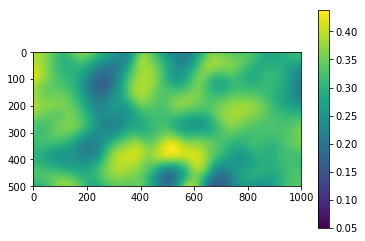

In [52]:
# Plot heterogeneous 2D por_vals 
plt.imshow(por, interpolation='Nearest')
plt.colorbar()

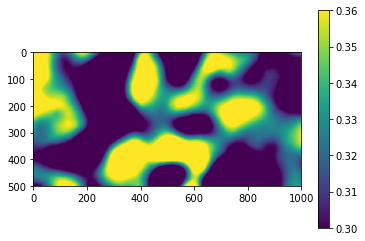

In [53]:
# Plot heterogeneous 2D por_vals 
plt.imshow(por, interpolation='Nearest', vmin=0.30, vmax=0.36)
plt.colorbar()

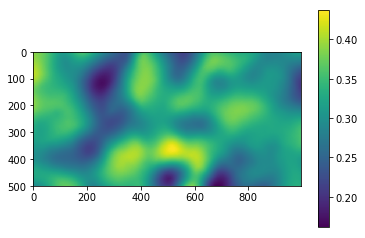

In [54]:
# Plot heterogeneous 2D por_vals without boundaries - there is a shortcut to do this
plt.imshow(por[0:499,1:998], interpolation='Nearest')
plt.colorbar()

#Next three cells are just for checking results computed above

In [55]:
np.log(hk[0:5, 0:5])

array([[ 7.605,  2.514,  2.521,  2.517,  2.506],
       [ 7.605,  2.518,  2.517,  2.514,  2.511],
       [ 7.605,  2.519,  2.518,  2.519,  2.513],
       [ 7.605,  2.518,  2.519,  2.515,  2.517],
       [ 7.605,  2.533,  2.518,  2.515,  2.513]])

In [56]:
part_result = 0.0983*np.log(hk[0:5, 0:5])+0.1426
print(part_result)

[[ 0.89   0.39   0.39   0.39   0.389]
 [ 0.89   0.39   0.39   0.39   0.389]
 [ 0.89   0.39   0.39   0.39   0.39 ]
 [ 0.89   0.39   0.39   0.39   0.39 ]
 [ 0.89   0.392  0.39   0.39   0.39 ]]


In [57]:
final = part_result
print(final)

[[ 0.89   0.39   0.39   0.39   0.389]
 [ 0.89   0.39   0.39   0.39   0.389]
 [ 0.89   0.39   0.39   0.39   0.39 ]
 [ 0.89   0.39   0.39   0.39   0.39 ]
 [ 0.89   0.392  0.39   0.39   0.39 ]]


In [58]:
# Note array of average porosities has indexes 0 to 4 not 1 to 5 to match zones
ave_por= np.zeros(5)
for i in range (0,5):
    ave_por[i] = np.average(por[zone==i+1])
    print(ave_por[i])

0.244347126313
0.309228146532
0.350123574242
0.386506553816
0.05


In [59]:
#Put ave porosities into each cell of por_vals array

In [60]:
por_vals = por
for i in range (0,5):
    por_vals[zone == i+1] = ave_por[i]

In [61]:
print (por_vals[0:100, 0:100])

[[ 0.05   0.387  0.387 ...,  0.309  0.309  0.309]
 [ 0.05   0.387  0.387 ...,  0.309  0.309  0.309]
 [ 0.05   0.387  0.387 ...,  0.309  0.309  0.309]
 ..., 
 [ 0.05   0.387  0.387 ...,  0.309  0.309  0.309]
 [ 0.05   0.387  0.387 ...,  0.309  0.309  0.309]
 [ 0.05   0.387  0.387 ...,  0.309  0.309  0.309]]


In [62]:
por_vals[0:499,1:998].size

497503

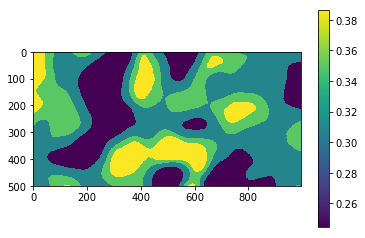

In [63]:
#Plot zones with average porosity within 4 zones (5th is just single cell high K boundary at left and right and low porosity) 
plt.imshow(por_vals[0:499,1:998], interpolation='Nearest')
plt.colorbar()

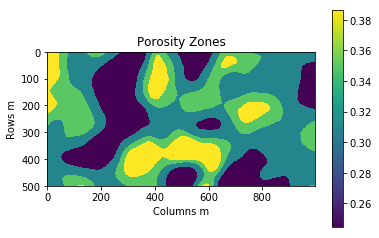

In [64]:
#Plot zones with average porosity within 4 zones (5th is just single cell high K boundary at left and right) 
plt.imshow(por_vals[0:499,1:998], interpolation='Nearest')
plt.colorbar()
plt.title("Porosity Zones")
plt.xlabel("Columns m")
plt.ylabel("Rows m")


The next cell writes MODPATH input files and runs MODPATH.  The results are the particle endpoints along the left boundary (they are reversed tracked from the observation locations), and the travel time from the observation location and the boundary.  I used the Pandas data analysis package to read endpoint information.

In [66]:
# prepare Modpath files   
# Change pososity from 0.20 to array por_vals of 5 zonal values shown above
SimulationType = 1 # 1 endpoint; 2 pathline; 3 timeseries
TrackingDirection = 2 # 1 forward; 2 backward
WeakSinkOption = 1 # 1 pass; 2 stop
WeakSourceOption = 1 # 1 pass; 2 stop
ReferemceTimeOption = 2 # 1 time value; 2 stress period, time step, relative offset
StopOption = 2 # 1 stop with simulation 2; extend if steady state 3; specify time
ParticleGenerationOption = 2 # 1 automatic; 2 external file
TimePointOption = 1 # 1 none; 2 number at fixed intervals; 3 array
BudgetOutputOption = 2 # 1 none; 2 summary; 3 list of cells; 4 trace mode
ZoneArrayOption = 1 # 1 none; 2 read zone array(s) 
RetardationOption = 1 # 1 none; 2 read array(s) 
AdvectiveObservationsOption = 1 # 1 none; 2 saved for all time pts 3; saved for final time pt

options = [SimulationType, TrackingDirection, WeakSinkOption, WeakSourceOption, ReferemceTimeOption, 
           StopOption, ParticleGenerationOption, TimePointOption, BudgetOutputOption, ZoneArrayOption, 
           RetardationOption, AdvectiveObservationsOption]
# Change approach to getting dis file name so maybe can get rid of the call to dis
#dis_file = dis.file_name[0]
dis_file = '{}.dis'.format(ml.name)
head_file = '{}.hds'.format(ml.name)
bud_file = '{}.cbc'.format(ml.name)

#mp = fp.modpath.Modpath(modelname=ml.name, modflowmodel=ml, dis_file=dis_file, 
#head_file=head_file, budget_file=bud_file)

mp = fp.modpath.Modpath(modelname=ml.name, modflowmodel=ml, dis_file=dis_file, head_file=head_file, budget_file=bud_file)   

mpnf = '{}.mpnam'.format(ml.name)
mplf = '{}.mplst'.format(ml.name)
mpef = '{}.mpend'.format(ml.name)

mpsim = fp.modpath.ModpathSim(mp, mp_name_file=mpnf, 
                              mp_list_file=mplf, 
                              option_flags=options,
                              ref_time_per_stp=[1, 1, 1.0],
#                               stop_zone=0,
#                               zone=zone_array,
                              extension='mpsim')

# Added to detach modpath from modflow; kept def of ibound above with modflow pars
hnoflo = -999.99
hdry = -888.88
# Change porosity input to ModpathBas routine
mpbas = fp.modpath.ModpathBas(mp, hnoflo=hnoflo, hdry=hdry, def_face_ct=0, 
                              laytyp=0, ibound=ibound, prsity=por_vals, prsityCB=0.20)

#mpbas = fp.modpath.ModpathBas(mp, hnoflo=bas.hnoflo, hdry=upw.hdry, def_face_ct=0, 
#                              laytyp=0, ibound=ibound, prsity=0.20, prsityCB=0.20)

mp.write_input()

In [67]:
ml


MODFLOW 1 layer(s), 500 row(s), 1000 column(s), 1 stress period(s)

In [68]:
head_file

'D_Flow1.hds'

In [69]:
dis_file

'D_Flow1.dis'

In [71]:
mpsf = '{}.mpsim'.format(ml.name)
# Changed name and location of .exe for modpath
mp_exe_name = 'C:/WRDAPP/modpath.6_0/bin/mp6x64.exe'
xstr = '{} {}'.format(mp_exe_name, mpsf)

exstat = os.system(xstr)
if exstat != 0:
    print ('MODPATH did not execute properly')
else:
    print ('MODPATH executed properly')

MODPATH executed properly


Read endpoints using Pandas.

In [72]:
endpoint_file = '{}.mpend'.format(ml.name)

i = 0
with open(endpoint_file) as f:
    while True:
        line = f.readline()
        i += 1
        if 'END HEADER' in line:
            break
        elif not line:
            break

cols = ['Particle ID', 'Particle Group', 'Status', 'Initial Time', 'Final Time', 'Initial Grid', 
        'Initial Layer', 'Initial Row', 'Initial Column', 'Initial Cell Face', 'Initial Zone', 
        'Initial Local X', 'Initial Local Y', 'Initial Local Z', 'Initial Global X', 'Initial Global Y', 
        'Initial Global Z', 'Final Grid', 'Final Layer', 'Final Row', 'Final Column', 'Final Cell Face', 
        'Final Zone', 'Final Local X', 'Final Local Y', 'Final Local Z', 'Final Global X', 
        'Final Global Y', 'Final Global Z', 'Label']            

ep_data = pd.read_table(endpoint_file, names=cols, header=None, skiprows=i, delim_whitespace=True)

Extract an array from the Pandas data frame

In [73]:
travel_time = ep_data['Final Time'].values

In [74]:
travel_time

array([  911.064,   377.256,  3872.41 ,   341.905,  4003.326,  1889.987,
        3715.592,  2767.482,  1260.892,  5619.453,  2402.869,  1556.514,
        1479.003,  2314.275,  2241.937,  3497.441,  3422.782,   985.073,
        1467.804,  2919.579,   372.092,  2797.585,  1750.556,  4982.585,
        4099.633,  1550.325,  1661.246,  5420.38 ,   727.128,  1421.983,
        1030.396,  2755.615,  1139.419,  2420.544,  5515.272,  1745.986,
        2611.716,  2043.333,   325.534,   350.547,  2832.275,  1163.33 ,
         750.891,  1149.067,   293.613,  2330.934,  2962.331,  2565.034,
        6455.604,  1276.529])

#With 4 posrosities: Plot the travel times at the observation points. 

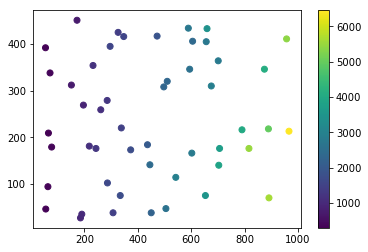

In [75]:
plt.scatter(obs_data[:,0], obs_data[:,1], c=travel_time)
plt.colorbar()

Former Plot below (do not re-run): Plot the travel times at the observation points. 

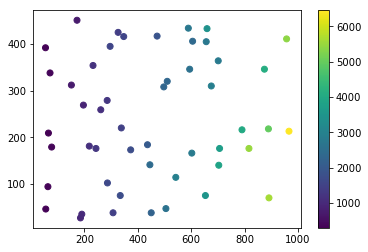

In [76]:
plt.scatter(obs_data[:,0], obs_data[:,1], c=travel_time)
plt.colorbar()

In [77]:
len(travel_time)

50

In [78]:
np.max(travel_time)

6455.6039709084998

In [79]:
np.min(travel_time)

293.61280798391698

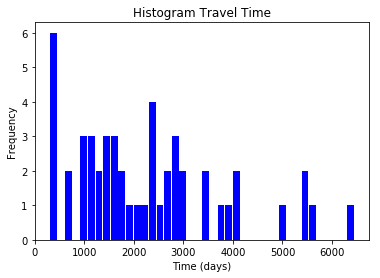

In [80]:
#new hist of travel time with 4 zones
plt.hist(travel_time, 40,rwidth=0.9, color='Blue')
plt.title("Histogram Travel Time")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
fig = plt.gcf()

In [83]:
#Add random error to observations with mean =0
meas_error=np.random.normal(0.0,0.0001,size = 50)
#meas_error=np.random.uniform(1.0,2.00,size = 200)
travel_time_witherr = travel_time + meas_error
print(travel_time[0:10])
print(meas_error[0:10])
print(travel_time_witherr[0:10])

[  911.064   377.256  3872.41    341.905  4003.326  1889.987  3715.592
  2767.482  1260.892  5619.453]
[-0. -0.  0.  0.  0. -0. -0.  0. -0.  0.]
[  911.064   377.256  3872.41    341.906  4003.326  1889.987  3715.592
  2767.482  1260.892  5619.454]


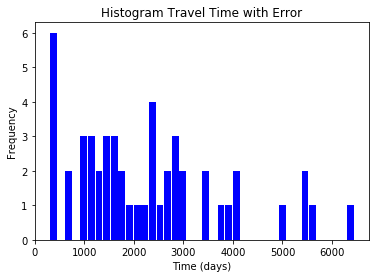

In [84]:
# new plot
plt.hist(travel_time_witherr, 40,rwidth=0.9, color='Blue')
plt.title("Histogram Travel Time with Error")
plt.xlabel("Time (days)")
plt.ylabel("Frequency")
fig = plt.gcf()

In [86]:
np.mean(travel_time)

2270.9624836090484

In [87]:
np.mean(travel_time_witherr)

2270.9624974970748

In [88]:
# Change ealier code to create file of age obs
# Assume for now can use "age" for obs name instead of "hd"
# Sept 14 Fix weight - for transport only PEST run - change it to 1.0)
fptr = open('D_Flow1aaAgeObs.txt','w')
obs = np.zeros(len(travel_time))
for num in range(0,len(travel_time)):
    obsname = "age" + str(num)
    # Aug 3 - changed to write travel time with error
    obs[num]= travel_time_witherr[num]
    # change name to coord not row & col & need to be sure have x, y straight - looks reversed to me on 7/16 at 2:25pm
    row = obs_data[num,0]
    col = obs_data[num,1]
    # Aug 9 tried 0.2, 0.1
    fptr.write("%10s %11s %5s %7s %5s %5s\n" % (obsname, str(obs[num]), str(1.0), "ages", str(row), str(col)))
fptr.close()